# Missing value imputation: RandomSampleImputer


The RandomSampleImputer works for both categorical and numerical variables. It will extract a random sample from the observations where data is available, and use it to replace the NA.

When no variable list is passed, it will default to all variables in the dataset.

**For this demonstration, we use the Ames House Prices dataset produced by Professor Dean De Cock:**

Dean De Cock (2011) Ames, Iowa: Alternative to the Boston Housing
Data as an End of Semester Regression Project, Journal of Statistics Education, Vol.19, No. 3

http://jse.amstat.org/v19n3/decock.pdf

https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627

The version of the dataset used in this notebook can be obtained from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.imputation import RandomSampleImputer

In [2]:
data = pd.read_csv('houseprice.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), data['SalePrice'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((1022, 79), (438, 79))

## Imputation in batch with a 1 seed

In [4]:
# note that the imputer has a random_state option for reproducibility
# more on the seed for the imputer in the documentation

random_imputer = RandomSampleImputer(
    variables=['Alley', 'MasVnrType', 'LotFrontage', 'MasVnrArea'],
    random_state=10 # all observations will be imputed in batch with one seed
)

random_imputer.fit(X_train)

RandomSampleImputer(random_state=10,
                    variables=['Alley', 'MasVnrType', 'LotFrontage',
                               'MasVnrArea'])

In [5]:
# the imputer saves a copy of the variables from the training set to impute new data

random_imputer.X_.head()

,Alley,MasVnrType,LotFrontage,MasVnrArea
64,NaN,BrkFace,NaN,573.0
682,NaN,None,NaN,0.0
960,NaN,None,50.0,0.0
1384,NaN,None,60.0,0.0
1100,NaN,None,60.0,0.0


In [6]:
# missing data in original train set

X_train[['Alley', 'MasVnrType', 'LotFrontage', 'MasVnrArea']].isnull().mean()

Alley          0.939335
MasVnrType     0.004892
LotFrontage    0.184932
MasVnrArea     0.004892
dtype: float64

In [7]:
# perform the imputation

train_t = random_imputer.transform(X_train)
test_t = random_imputer.transform(X_test)

In [8]:
# no missing data after the transformation

train_t[['Alley', 'MasVnrType', 'LotFrontage', 'MasVnrArea']].isnull().mean()

Alley          0.0
MasVnrType     0.0
LotFrontage    0.0
MasVnrArea     0.0
dtype: float64

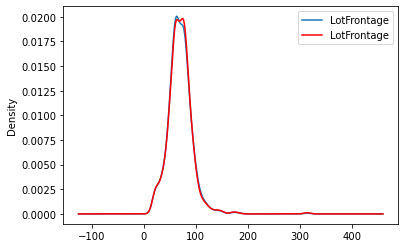

In [9]:
# when using the random sample imputer, the distribution of the variable does not change
# useful for models that are sensitive to the variable distribution

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

## Seeding on variables, at observation level

The seed will be calculated observation per observation, either by adding or multiplying the seeding variable values, and passed to the random_state. Then, a value will be extracted from the train set using that seed and  used to replace the NAN in particular observation.

**To know more about how the observation per seed is used check this [notebook](https://github.com/solegalli/feature-engineering-for-machine-learning/blob/master/Section-04-Missing-Data-Imputation/04.07-Random-Sample-Imputation.ipynb)** 

In [10]:
imputer_obs = RandomSampleImputer(
    random_state=['MSSubClass', 'YrSold'], # the values of these variables will be used as seed
    seed='observation',# 1 seed per observation, determined by the values of the above variables 
    seeding_method='add' # we add the values of these variables to create the seed
)

imputer_obs.fit(X_train)

RandomSampleImputer(random_state=['MSSubClass', 'YrSold'], seed='observation',
                    variables=['MSSubClass', 'MSZoning', 'LotFrontage',
                               'LotArea', 'Street', 'Alley', 'LotShape',
                               'LandContour', 'Utilities', 'LotConfig',
                               'LandSlope', 'Neighborhood', 'Condition1',
                               'Condition2', 'BldgType', 'HouseStyle',
                               'OverallQual', 'OverallCond', 'YearBuilt',
                               'YearRemodAdd', 'RoofStyle', 'RoofMatl',
                               'Exterior1st', 'Exterior2nd', 'MasVnrType',
                               'MasVnrArea', 'ExterQual', 'ExterCond',
                               'Foundation', 'BsmtQual', ...])

In [11]:
# takes a copy of the entire train set

imputer_obs.X_

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
64,60,RL,NaN,9375,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,NaN,0,2,2009,WD,Normal
682,120,RL,NaN,2887,Pave,NaN,Reg,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2008,WD,Normal
960,20,RL,50.0,7207,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
1384,50,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal
1100,30,RL,60.0,8400,Pave,NaN,Reg,Bnk,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,1,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,60,RL,82.0,9430,Pave,NaN,Reg,Lvl,AllPub,Inside,...,180,0,NaN,NaN,NaN,0,7,2009,WD,Normal
835,20,RL,60.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
1216,90,RM,68.0,8930,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
559,120,RL,NaN,3196,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal


In [12]:
# imputes all variables

train_t = random_imputer.transform(X_train)
test_t = random_imputer.transform(X_test)

In [13]:
# no more missing data in any variable
test_t.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64

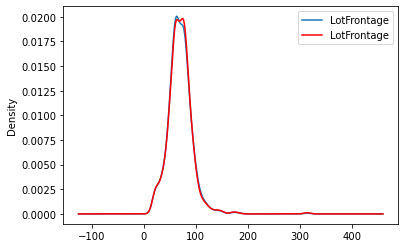

In [14]:
# when using the random sample imputer, the distribution of the variable does not change

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')